In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# A. Data preparation

# 1. Trainging Data

## 1.1. Demographic

In [2]:
Demog = pd.read_csv('Model Build - Demographics.csv', sep = ',',encoding='latin-1')
Demog.head(2)

,Client ID,Age,"Gender 1: Female, 2: Male",County,Income Group,Unnamed: 5
0,1,36,1,Cork,10001 - 40000,NaN
1,2,43,1,Cavan,0 - 10000,NaN


In [3]:
Demog.drop('Unnamed: 5',axis=1,inplace=True)
Demog.columns = ['ClientID','Age','Sex','County','IncomeGroup']

Demog.info()
print('\n')
print(Demog.describe())
print('\n')
print(Demog.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10004 entries, 0 to 10003
Data columns (total 5 columns):
ClientID       10004 non-null int64
Age            10004 non-null int64
Sex            10004 non-null object
County         10001 non-null object
IncomeGroup    10004 non-null object
dtypes: int64(2), object(3)
memory usage: 390.9+ KB


           ClientID           Age
count  10004.000000  10004.000000
mean    4999.361755     44.392043
std     2887.051613     15.202030
min        1.000000     20.000000
25%     2499.750000     32.000000
50%     4998.500000     44.000000
75%     7499.250000     57.000000
max    10000.000000    200.000000


ClientID       10004
Age            10004
Sex            10004
County         10001
IncomeGroup    10004
dtype: int64


** There are 3 missing values in the "County" variable" **

### 1.1.1. Re-encoding the gender variable as follows:
- Female: 1
- Male: 0

### a) Before the re-encoding

In [4]:
print(Demog.Sex.value_counts())
print(Demog.Sex.unique())

1         5088
0         4907
M            3
fem          2
Male         1
female       1
m            1
f            1
Name: Sex, dtype: int64
['1' '0' 'M' 'Male' 'f' 'fem' 'm' 'female']


In [5]:
# Female:1
# Male: 0
t = Demog.Sex.replace('fem',1).replace('female',1).replace('f',1).replace('1',1)
t = t.replace('M',0).replace('m',0).replace('Male',0).replace('0',0)
Demog.Sex = t

### b) After the re-encoding


In [6]:
print(Demog.Sex.value_counts())
print(Demog.Sex.unique())

1    5092
0    4912
Name: Sex, dtype: int64
[1 0]


### 1.1.2. Cleaning the IncomeGroup variable

In [7]:
Demog.IncomeGroup.value_counts()

10001 - 40000     5583
60001 - 100000    1736
40001 - 60000     1175
100000+           1135
0 - 10000          370
10001 ? 40000        2
10001 ?. 40000       1
10002 - 40000        1
0  ? 10000           1
Name: IncomeGroup, dtype: int64

In [8]:
t = Demog.IncomeGroup.replace('10001 ?. 40000','10001 - 40000').replace('10001 ? 40000','10001 - 40000')
t = t.replace('0  ? 10000','0 - 10000').replace('10002 - 40000','10001 - 40000')

In [9]:
Demog.IncomeGroup = t
Demog.IncomeGroup.value_counts()

10001 - 40000     5587
60001 - 100000    1736
40001 - 60000     1175
100000+           1135
0 - 10000          371
Name: IncomeGroup, dtype: int64

### 1.1.3. Dropping the rows having some missing values of County variable

Indeed, there are only 3 missing values on a total of around 10000 observations. Consequently, we decide to drop the corresponding rows

In [10]:
ClientID_County_Invalid = list(Demog[Demog.County.isnull()].ClientID)
ClientID_County_Invalid

[9796, 9892, 9968]

### However, some County values contains some number (e.g. Dublin 4). Let us remove these number using the following function

In [11]:
demIntFromString = lambda x : (''.join([c for c in str(x) if not c.isdigit()])).strip()

In [12]:
Demog.County = Demog.County.map(demIntFromString)

In [13]:
ClientID_County_Invalid = list(Demog[Demog.County == ''].ClientID)
ClientID_County_Invalid

[7935, 8099, 8201]

### 1.1.4. Outliers: Age

In [14]:
print(Demog[Demog.Age>150])
ClientID_Age_Invalid = list(Demog[Demog.Age>150].ClientID)
print(ClientID_Age_Invalid)

      ClientID  Age  Sex     County     IncomeGroup
1898      1897  200    1  Waterford   10001 - 40000
3898      3895  200    1       Cork  60001 - 100000
5898      5895  200    1     Dublin         100000+
7898      7895  200    1       Cork   10001 - 40000
9898      9895  200    1     Dublin  60001 - 100000
[1897, 3895, 5895, 7895, 9895]


## 1.2. Loan data

In [15]:
Loan = pd.read_csv('Model Build - Previous Loan Holdings.csv', sep = ',',encoding='latin-1')
Loan.head(2)

,Client ID,Held Loan previously
0,1,1
1,2,0


In [16]:
Loan.columns = ['ClientID','HeldLoanPreviously']
Loan.info()
print('\n')
print(Loan.describe())
print('\n')
print(Loan.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10005 entries, 0 to 10004
Data columns (total 2 columns):
ClientID              10005 non-null int64
HeldLoanPreviously    10005 non-null object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


           ClientID
count  10005.000000
mean    4998.864168
std     2887.336318
min        1.000000
25%     2499.000000
50%     4998.000000
75%     7499.000000
max    10000.000000


ClientID              10005
HeldLoanPreviously    10005
dtype: int64


### 1.2.1. Function IsInt

** Some of the Strings does not represent some integer. The following function IsInt tries to detect the rows of these cases**

In [17]:
def IsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

## 1.2.2. Invalid loans

In [18]:
Loan_invalid=[]
for j in range(len(Loan)):
    if not IsInt(Loan.HeldLoanPreviously[j]):
        Loan_invalid.append(j)
ClientID_Loan_invalid = list(Loan.ClientID[Loan_invalid])
print(ClientID_Loan_invalid)

[28, 70, 73, 111, 170]


## 1.3. Products

In [19]:
Products = pd.read_csv('Model Build - Product Held in Bank.csv',header=None, sep = ',',encoding='latin-1')
Products.head(2)

,0,1
0,1,4
1,2,4


In [20]:
Products.columns = ['ClientID','NumberProducts']
Products.ClientID.value_counts().head(6)
Products.head(2)
Products.info()
print('\n')
print(Products.describe())
print('\n')
print(Products.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10004 entries, 0 to 10003
Data columns (total 2 columns):
ClientID          10004 non-null int64
NumberProducts    10004 non-null object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


           ClientID
count  10004.000000
mean    4999.361755
std     2887.051613
min        1.000000
25%     2499.750000
50%     4998.500000
75%     7499.250000
max    10000.000000


ClientID          10004
NumberProducts    10004
dtype: int64


### 1.3.1 Invalid products

In [21]:
Products_invalid = []
for j in range(len(Products)):
    if not IsInt(Products.NumberProducts[j]):
        Products_invalid.append(j)
ClientID_Products_invalid = list(Products.ClientID[Products_invalid])
print(ClientID_Products_invalid)

[6658]


## 1.4. Transactions

### 1.4.1. After inspecting the ClientID of the other training data set files, we considered that the training data and test data were interchanged.

In [22]:
Transactions = pd.read_csv('Test Sample/TEST - Transactions out of Current Account.csv', sep = ',',encoding='latin-1')
Transactions.head(2)

,Client,Num Transactions,Last TXN Amount,Merchant Code,Last Transaction Narrative,Unnamed: 5,Unnamed: 6,Unnamed: 7,0
0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,17.0,83.66,7211.0,THE BRIDGE LAUNDRY WICKLOW TOWN,NaN,NaN,NaN,NaN


In [23]:
Transactions.drop(['Unnamed: 5','Unnamed: 6','Unnamed: 7','0'],axis=1,inplace=True)
Transactions.columns = ['ClientID','NumTransactions','LastTXNAmount','MerchantCode','LastTransactionNarrative']
Transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11221 entries, 0 to 11220
Data columns (total 5 columns):
ClientID                    10004 non-null float64
NumTransactions             10004 non-null float64
LastTXNAmount               6724 non-null float64
MerchantCode                6724 non-null float64
LastTransactionNarrative    6724 non-null object
dtypes: float64(4), object(1)
memory usage: 438.4+ KB


### 1.4.2. Useless supplementary rows

In [24]:
Transactions.tail(2)

,ClientID,NumTransactions,LastTXNAmount,MerchantCode,LastTransactionNarrative
11219,NaN,NaN,NaN,NaN,NaN
11220,NaN,NaN,NaN,NaN,NaN


### Some rows of Transactions table are missing values and this is highlighted below 

In [25]:
Transactions[Transactions.ClientID.isnull()].head(2)

,ClientID,NumTransactions,LastTXNAmount,MerchantCode,LastTransactionNarrative
10004,NaN,NaN,NaN,NaN,NaN
10005,NaN,NaN,NaN,NaN,NaN


In [26]:
Transactions[Transactions.ClientID.isnull()].tail(2)

,ClientID,NumTransactions,LastTXNAmount,MerchantCode,LastTransactionNarrative
11219,NaN,NaN,NaN,NaN,NaN
11220,NaN,NaN,NaN,NaN,NaN


### As we can observe the last ClientID of the precedent tables is 10000

In [27]:
print(Demog.ClientID.sort_values().tail(1))
print(Loan.ClientID.tail(1).sort_values().tail(1))
print(Products.ClientID.tail(1).sort_values().tail(1))

10003    10000
Name: ClientID, dtype: int64
10004    10000
Name: ClientID, dtype: int64
10003    10000
Name: ClientID, dtype: int64


In [28]:
Transactions = Transactions[Transactions.ClientID <=10000]

### 1.4.2. Handling missing values 

In [29]:
index_NaN_MerchantCode = Transactions[Transactions.MerchantCode.isnull()].index
index_NaN_LastTXNAmount = Transactions[Transactions.LastTXNAmount.isnull()].index
index_Null_Numb_Transactions = Transactions[Transactions.NumTransactions == 0].index


In [30]:
print('Total number of missing values in MerchantCode column is:',len(index_NaN_MerchantCode))
print('Total number of missing values in LastTXNAmount column is:',len(index_NaN_LastTXNAmount))
print('Total number of null values in the NumTransactions column is:',len(index_Null_Numb_Transactions))
print('\n')
print('Total number of null NumTransactions and NaN MerchantCode:',sum(index_Null_Numb_Transactions==index_NaN_MerchantCode))
print('Total number of null NumTransactions and NaN LastTXNAmount:',sum(index_Null_Numb_Transactions==index_NaN_LastTXNAmount))

Total number of missing values in MerchantCode column is: 3280
Total number of missing values in LastTXNAmount column is: 3280
Total number of null values in the NumTransactions column is: 3280


Total number of null NumTransactions and NaN MerchantCode: 3280
Total number of null NumTransactions and NaN LastTXNAmount: 3280


- ###  Hence, we have shown that LastTXNAmount and MerchantCode are NaN when NumTransactions == 0.
- ### Consequently we will replace the missing values by a zero

In [31]:
Transactions.LastTXNAmount.fillna(0,inplace=True)
Transactions.MerchantCode.fillna(0,inplace=True)

### Let us keep only the variables ClientID and LastTXNAmount which are the most important in our point of view

In [32]:
Transactions = Transactions[['ClientID', 'LastTXNAmount']]
Transactions.ClientID = Transactions.ClientID.map(int)
Transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10004 entries, 0 to 10003
Data columns (total 2 columns):
ClientID         10004 non-null int64
LastTXNAmount    10004 non-null float64
dtypes: float64(1), int64(1)
memory usage: 234.5 KB


## 1.5. TXN

In [33]:
TXN = pd.read_csv('Model Build - TXN Amount.csv', header=None, sep = ',',encoding='latin-1')
TXN.head(2)

,0,1
0,1,58
1,2,"2,663"


In [34]:
TXN = pd.read_csv('Model Build - TXN Amount.csv', header=None, sep = ',',encoding='latin-1')
TXN.columns = ['ClientID','AverageNumbCA']
TXN.AverageNumbCA = TXN.AverageNumbCA.apply(lambda x: np.float(x[1:].replace(',','')))
TXN.head(3)

,ClientID,AverageNumbCA
0,1,58.0
1,2,2663.0
2,3,46.0


In [35]:
TXN.info()
print('\n')
print(TXN.describe())
print('\n')
print(TXN.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10004 entries, 0 to 10003
Data columns (total 2 columns):
ClientID         10004 non-null int64
AverageNumbCA    10004 non-null float64
dtypes: float64(1), int64(1)
memory usage: 156.4 KB


           ClientID  AverageNumbCA
count  10004.000000   10004.000000
mean    4999.361755     444.820572
std     2887.051613     877.371286
min        1.000000       0.000000
25%     2499.750000       0.000000
50%     4998.500000      30.000000
75%     7499.250000     402.000000
max    10000.000000    9470.000000


ClientID         10004
AverageNumbCA    10004
dtype: int64


## 1.6. Flag Loan

In [36]:
Flag_Loan = pd.read_csv('Target Variable - Purchased Loan Flag.csv', sep = ',',encoding='latin-1')
Flag_Loan.head(2)

,Client ID,Loan Flag,Unnamed: 2,Unnamed: 3
0,1,0,NaN,NaN
1,2,0,NaN,NaN


In [37]:
Flag_Loan = pd.read_csv('Target Variable - Purchased Loan Flag.csv', sep = ',',encoding='latin-1')
Flag_Loan.drop(['Unnamed: 2','Unnamed: 3'],axis=1,inplace=True)
Flag_Loan.columns = ['ClientID','LoanFlag']
Flag_Loan.reset_index(drop=True,inplace=True)
Flag_Loan.head(2)

,ClientID,LoanFlag
0,1,0
1,2,0


In [38]:
Flag_Loan.info()
print('\n')
print(Flag_Loan.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10004 entries, 0 to 10003
Data columns (total 2 columns):
ClientID    10004 non-null int64
LoanFlag    10004 non-null int64
dtypes: int64(2)
memory usage: 156.4 KB


           ClientID      LoanFlag
count  10004.000000  10004.000000
mean    4999.361755      0.021092
std     2887.051613      0.143697
min        1.000000      0.000000
25%     2499.750000      0.000000
50%     4998.500000      0.000000
75%     7499.250000      0.000000
max    10000.000000      1.000000


## 1.7. County

In [39]:
County = pd.read_excel('County Lkp.xlsx', sep = ',',encoding='latin-1')
County.head(2)

,SNo,County,Population,Density (/ km2),Rank,Province,Change since
0,NaN,NaN,NaN,NaN,NaN,NaN,previous census
1,1,Dublin,1273069.0,1380.8,1,Leinster,0.0702


In [40]:
County.drop(County.index[0],inplace=True)
County.reset_index(drop=True,inplace=True)
County.tail(7)

,SNo,County,Population,Density (/ km2),Rank,Province,Change since
36,32,Leitrim,31796.0,19.9,32,Connacht,0.0984
37,NaN,Average,199974.0,NaN,NaN,NaN,NaN
38,NaN,Ireland,6469688.0,76.6,Total,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,For other more formats kindly visit www.downlo...,NaN,NaN,NaN,NaN,NaN,NaN
41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,Original source : en.wikipedia.org/wiki/List_o...,NaN,NaN,NaN,NaN,NaN,NaN


### Useless rows beyong row number 36

In [41]:
County = County[County.index<37]
County.tail()

,SNo,County,Population,Density (/ km2),Rank,Province,Change since
32,28,Fermanagh,61170.0,36.1,28,Ulster,0.0633
33,29,Monaghan,60483.0,46.7,29,Ulster,0.0801
34,30,Carlow,54612.0,60.8,30,Leinster,0.0847
35,31,Longford,39000.0,35.7,31,Leinster,0.134
36,32,Leitrim,31796.0,19.9,32,Connacht,0.0984


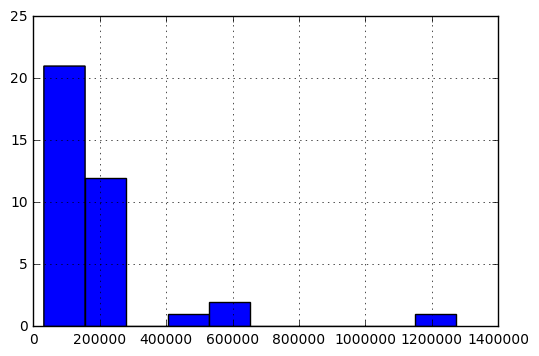

In [44]:
%matplotlib inline
County.Population.hist()


In [45]:
print(County.Population.describe())
print(sum(County.Population>300000))

count    3.700000e+01
mean     1.973838e+05
std      2.261722e+05
min      3.179600e+04
25%      7.668700e+04
50%      1.366400e+05
75%      2.062610e+05
max      1.273069e+06
Name: Population, dtype: float64
4


### 1.7.1. Binning County population
The idea of this process is to categorize the Counties in three main categories:
- NormalSize: $County.Population \gt County.Population.median()$
- LargeSize: $County.Population\leq County.Population.median()$

In [46]:
p = County.Population.values

bins = [0, np.median(p), np.max(p)+1]
group_names = ['NormalSize', 'LargeSize']
County['Population_class'] = pd.cut(County['Population'], bins, labels=group_names)
County_population_cat = County[['County','Population_class']]
County_population_cat.head()

,County,Population_class
0,Dublin,LargeSize
1,Antrim,LargeSize
2,Down,LargeSize
3,Cork,LargeSize
4,Fingal,LargeSize


## 1.8. Clients/Rows to drop

### 1.8.1. We can notice below that the clients with ID: 21, 46, 1220, 3674 and 3675 are recorded more than one time (twice).

In [47]:
t1 = Demog.ClientID.value_counts()>1
print(list(t1[t1.values == True].index))
t2 = Loan.ClientID.value_counts()>1
print(list(t2[t2.values == True].index))
t3 = Products.ClientID.value_counts()>1
print(list(t3[t3.values == True].index))
t4 = TXN.ClientID.value_counts()>1
print(list(t4[t4.values == True].index))
t5 = Flag_Loan.ClientID.value_counts()>1
print(list(t5[t5.values == True].index))

[1220, 46, 3674, 3675]
[1220, 21, 3675, 3674, 46]
[1220, 46, 3674, 3675]
[1220, 46, 3674, 3675]
[1220, 46, 3674, 3675]


 ### 1.8.2. And the different records are not identical

In [48]:
r_twice = [21, 46, 1220, 3674, 3675]
print(Demog[Demog.ClientID.isin( r_twice)],'\n')
print(Loan[Loan.ClientID.isin( r_twice)],'\n')
print(Products[Products.ClientID.isin( r_twice)],'\n')
print(Transactions[Transactions.ClientID.isin( r_twice)],'\n')
print(TXN[TXN.ClientID.isin( r_twice)],'\n')
print(Flag_Loan[Flag_Loan.ClientID.isin( r_twice)],'\n')

      ClientID  Age  Sex     County    IncomeGroup
20          21   48    1     Dublin  10001 - 40000
45          46   56    0      Kerry  10001 - 40000
46          46   20    0      Laois  10001 - 40000
1220      1220   67    0  Tipperary  10001 - 40000
1221      1220   48    1    Kildare        100000+
3675      3674   46    0     Galway  10001 - 40000
3676      3674   37    1     Carlow  10001 - 40000
3677      3675   56    1     Dublin      0 - 10000
3678      3675   23    1       Cork  10001 - 40000 

      ClientID HeldLoanPreviously
20          21                  1
21          21                  0
46          46                  0
47          46                  0
1221      1220                  0
1222      1220                  0
3676      3674                  0
3677      3675                  0
3678      3674                  0
3679      3675                  1 

      ClientID NumberProducts
20          21              3
45          46              3
46          46        

### 1.8.3. Hence we will drop the rows with ClientID belonging to r_twice and the previous invalid detected previously

In [49]:
rows_to_drop = ClientID_Age_Invalid + r_twice + ClientID_Loan_invalid + ClientID_Products_invalid
print(rows_to_drop)

[1897, 3895, 5895, 7895, 9895, 21, 46, 1220, 3674, 3675, 28, 70, 73, 111, 170, 6658]


### a) Function DropRecords

In [50]:
def DropRecords(df,rows_to_drop):
    for r in rows_to_drop:
        df = df.drop(df[df.ClientID == r].index)
        df.reset_index(drop=True,inplace=True)
    return df 

In [52]:
Demog = DropRecords(Demog,rows_to_drop)
Loan = DropRecords(Loan,rows_to_drop)
Products = DropRecords(Products,rows_to_drop)
Transactions = DropRecords(Transactions,rows_to_drop)
TXN = DropRecords(TXN,rows_to_drop)
Flag_Loan = DropRecords(Flag_Loan,rows_to_drop)


### b) Converting into integer the elements of the columns Loan.HeldLoanPreviously of Products.NumberProducts

In [53]:
Loan.HeldLoanPreviously = Loan.HeldLoanPreviously.map(int)
Products.NumberProducts = Products.NumberProducts.map(int)

# B. Business Intelligence

## 1.0. Checking that all the tables are well aligned (ClientID in the same order)
- ** Indeed, if this holds, we can juste concatenate directly all the tables, and this avoid doing join/merge **.
- ** As we can see below, this is true **

In [54]:
print(len(Demog.ClientID))
print(sum(Demog.ClientID == Transactions.ClientID))
print(sum(Demog.ClientID == TXN.ClientID))
print(sum(Demog.ClientID == Products.ClientID))
print(sum(Demog.ClientID == Flag_Loan.ClientID))

9984
9984
9984
9984
9984


##  1.1. How Many Customers above 50 years old have taken up a loan?

In [55]:
Demog_Loan = pd.concat([Demog,Loan.HeldLoanPreviously],axis=1)
Demog_Loan.head()

,ClientID,Age,Sex,County,IncomeGroup,HeldLoanPreviously
0,1,36,1,Cork,10001 - 40000,1
1,2,43,1,Cavan,0 - 10000,0
2,3,32,0,Dublin,10001 - 40000,0
3,4,52,1,Louth,40001 - 60000,1
4,5,63,0,Kilkenny,60001 - 100000,0


In [56]:
Above_50_Loan = Demog_Loan[(Demog_Loan.Age>50) & (Demog_Loan.HeldLoanPreviously==1)]

In [57]:
#Above_50_Loan.count()
t = len(Above_50_Loan)
print('There are %d customers above 50 years old and who have taken up a loan'%t)

There are 977 customers above 50 years old and who have taken up a loan


## Answer 1.1. :
### There are *977* customers above 50 years old and who have taken up a loan

## 1.2. How Many Females aged 30 to 40 have more than 2 products?

In [58]:
Demog_Products= pd.concat([Demog,Products.NumberProducts],axis=1)
Demog_Products.head()

,ClientID,Age,Sex,County,IncomeGroup,NumberProducts
0,1,36,1,Cork,10001 - 40000,4
1,2,43,1,Cavan,0 - 10000,4
2,3,32,0,Dublin,10001 - 40000,2
3,4,52,1,Louth,40001 - 60000,2
4,5,63,0,Kilkenny,60001 - 100000,1


In [59]:
Female_30_40_prod_2 = Demog_Products[(Demog_Products.Sex == 1) & (Demog_Products.Age>=30)
                                    & (Demog_Products.Age <=40) & (Demog_Products.NumberProducts >=2)]

In [60]:
len(Female_30_40_prod_2)

818

## Answer 1.2. :
### There are *818* Females aged 30 to 40 and having more than 2 products

## 1.3. What is the average number of Current Account(CA) Transactions for males who had a previous Loans ?

In [61]:
Demog_TXN = pd.concat([Demog,TXN.AverageNumbCA,Loan.HeldLoanPreviously],axis=1)
Demog_TXN.head()

,ClientID,Age,Sex,County,IncomeGroup,AverageNumbCA,HeldLoanPreviously
0,1,36,1,Cork,10001 - 40000,58.0,1
1,2,43,1,Cavan,0 - 10000,2663.0,0
2,3,32,0,Dublin,10001 - 40000,46.0,0
3,4,52,1,Louth,40001 - 60000,0.0,1
4,5,63,0,Kilkenny,60001 - 100000,126.0,0


In [62]:
Male_Demog_TXN = Demog_TXN[(Demog_TXN.Sex == 0) & (Demog_TXN.HeldLoanPreviously==1)]

In [63]:
print(np.round(Male_Demog_TXN.AverageNumbCA.mean(),2))

439.68


## Answer 1.3. :
### The average number of Current Account(CA) Transactions for males who had a previous Loans is *439.68*

## 1.4. How many females did not have a previous loans and who are aged
** - Less than 20 ==> 85**

** - 21 to 40     ==> 1425**

** - 40+          ==> 2326**


In [64]:
Demog_No_Loan_female_less_40 = Demog_Loan[(Demog_Loan.Sex==1) 
                                          & (Demog_Loan.HeldLoanPreviously==0) 
                                          & (Demog_Loan.Age<=20)]
len(Demog_No_Loan_female_less_40)

85

In [65]:
Demog_No_Loan_female_21_40 = Demog_Loan[(Demog_Loan.Sex==1) 
                                        & (Demog_Loan.HeldLoanPreviously==0)  
                                        & (Demog_Loan.Age<=40) 
                                        & (Demog_Loan.Age>=21) ]
len(Demog_No_Loan_female_21_40)

1425

In [66]:
Demog_No_Loan_female_over_40 = Demog_Loan[(Demog_Loan.Sex==1) 
                                          & (Demog_Loan.HeldLoanPreviously==0) 
                                          & (Demog_Loan.Age>40)]
len(Demog_No_Loan_female_over_40)

2326

# C. Predictive Modelling

# 1. Test data

## 1.1. Test Demographic

In [67]:
Demog_test = pd.read_csv('Test Sample/TEST - Demographics.csv', sep = ',',encoding='latin-1')
Demog_test.columns = ['ClientID','Age','Sex','County','IncomeGroup']
Demog_test.ClientID.value_counts().head(3)
Demog_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
ClientID       2000 non-null int64
Age            2000 non-null int64
Sex            2000 non-null int64
County         2000 non-null object
IncomeGroup    2000 non-null object
dtypes: int64(3), object(2)
memory usage: 78.2+ KB


In [68]:
print(Demog_test.describe())

           ClientID          Age          Sex
count   2000.000000  2000.000000  2000.000000
mean   11000.500000    48.386500     0.509000
std      577.494589    17.710193     0.500044
min    10001.000000    20.000000     0.000000
25%    10500.750000    33.000000     0.000000
50%    11000.500000    48.000000     1.000000
75%    11500.250000    63.000000     1.000000
max    12000.000000    80.000000     1.000000


## 1.2. Test Loans

In [69]:
Loan_test = pd.read_csv('Test Sample/TEST- Previous Loan Holdings.csv', sep = ',',encoding='latin-1')
Loan_test = Loan_test[['Client ID', 'Held Loan previously']]
Loan_test.columns = ['ClientID','HeldLoanPreviously']
Loan_test.ClientID.value_counts().head(5)
Loan_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10004 entries, 0 to 10003
Data columns (total 2 columns):
ClientID              10004 non-null int64
HeldLoanPreviously    10004 non-null int64
dtypes: int64(2)
memory usage: 156.4 KB


In [70]:
print(Loan_test.ClientID.head())
print(Loan_test.ClientID.tail())

0    10001
1    10002
2    10003
3    10004
4    10005
Name: ClientID, dtype: int64
9999     20000
10000    20001
10001    20002
10002    20003
10003    20004
Name: ClientID, dtype: int64


### Here we will only keep the 2000 customers having a ClientID in the range [10001,12000]

In [71]:
Loan_test = Loan_test[Loan_test.ClientID<=12000]
Loan_test.tail()
Loan_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 2 columns):
ClientID              2000 non-null int64
HeldLoanPreviously    2000 non-null int64
dtypes: int64(2)
memory usage: 46.9 KB


## 1.3. Test Products

In [72]:
Products_test = pd.read_csv('Test Sample/TEST - Product Held in Bank.csv', sep = ',',encoding='latin-1')
Products_test = Products_test[['Unnamed: 0', 'Unnamed: 1']]
Products_test.columns = ['ClientID','NumberProducts']
Products_test.drop(Products_test.index[0],inplace=True)
Products_test.reset_index(drop=True,inplace=True)
Products_test.ClientID = Products_test.ClientID.map(int)
Products_test.NumberProducts = Products_test.NumberProducts.map(int)
Products_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
ClientID          2000 non-null int64
NumberProducts    2000 non-null int64
dtypes: int64(2)
memory usage: 31.3 KB


## 1.4. Test Transactions

In [73]:
Transactions_test = pd.read_csv('Model Build - Transactions out of Current Account.csv', sep = ',',encoding='latin-1')
Transactions_test.columns = ['ClientID','NumTransactions','LastTXNAmount','MerchantCode','LastTransactionNarrative']
Transactions.ClientID = Transactions.ClientID.map(np.int)
Transactions_test = Transactions_test[['ClientID','LastTXNAmount']]
Transactions_test = Transactions_test.sort_values('ClientID')
Transactions_test.reset_index(drop=True,inplace=True)
Transactions_test.tail()

,ClientID,LastTXNAmount
1995,11996,766.85
1996,11997,60.83
1997,11998,561.44
1998,11999,1117.40
1999,12000,12.20


## 1.5. Test TXN

In [74]:
TXN_test = pd.read_csv('Test Sample/TEST - TXN Amount.csv', header=None, sep = ',',encoding='latin-1')
TXN_test.columns
TXN_test = TXN_test[[0,1]]
TXN_test.drop(TXN_test.index[[0,1]],inplace=True)
TXN_test.columns = ['ClientID','AverageNumbCA']
TXN_test.ClientID = TXN_test.ClientID.map(int)
TXN_test.AverageNumbCA = TXN_test.AverageNumbCA.apply(lambda x: np.float(x.replace(',','')))
TXN_test.reset_index(drop=True,inplace=True)
TXN_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
ClientID         2000 non-null int64
AverageNumbCA    2000 non-null float64
dtypes: float64(1), int64(1)
memory usage: 31.3 KB


# 2. Train and Test Global Data

## 2.1. Global train data frame

- We will concatenate the 6 different tables 
- Then, we will merge the resulting table with the County_population_cat table

In [75]:
tr = [Demog, 
      Loan.drop('ClientID',axis=1),
      Products.drop('ClientID',axis=1), 
      Transactions.drop('ClientID',axis=1),
      TXN.drop('ClientID',axis=1), 
      Flag_Loan.drop('ClientID',axis=1)]
df_train = pd.concat(tr,axis=1)

In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9984 entries, 0 to 9983
Data columns (total 10 columns):
ClientID              9984 non-null int64
Age                   9984 non-null int64
Sex                   9984 non-null int64
County                9984 non-null object
IncomeGroup           9984 non-null object
HeldLoanPreviously    9984 non-null int64
NumberProducts        9984 non-null int64
LastTXNAmount         9984 non-null float64
AverageNumbCA         9984 non-null float64
LoanFlag              9984 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 780.1+ KB


In [77]:
County_population_cat.set_index('County',drop=True,inplace=True)
County_population_cat.head()

,Population_class
County,
Dublin,LargeSize
Antrim,LargeSize
Down,LargeSize
Cork,LargeSize
Fingal,LargeSize


In [78]:
df_train = df_train.join(County_population_cat, on='County', how='left')
df_train.drop('County',axis=1,inplace=True)
df_train.head()

,ClientID,Age,Sex,IncomeGroup,HeldLoanPreviously,NumberProducts,LastTXNAmount,AverageNumbCA,LoanFlag,Population_class
0,1,36,1,10001 - 40000,1,4,0.00,58.0,0,LargeSize
1,2,43,1,0 - 10000,0,4,83.66,2663.0,0,NormalSize
2,3,32,0,10001 - 40000,0,2,526.18,46.0,0,LargeSize
3,4,52,1,40001 - 60000,1,2,70.68,0.0,0,NormalSize
4,5,63,0,60001 - 100000,0,1,259.07,126.0,0,NormalSize


## 2.2. Global test data frame


In [79]:
ts = [Demog_test, Loan_test.drop('ClientID',axis=1), Products_test.drop('ClientID',axis=1), 
      Transactions_test.drop('ClientID',axis=1), TXN_test.drop('ClientID',axis=1)]
df_test = pd.concat(ts,axis=1)
df_test.head()

,ClientID,Age,Sex,County,IncomeGroup,HeldLoanPreviously,NumberProducts,LastTXNAmount,AverageNumbCA
0,10001,59,1,Cork,10001 - 40000,0,4,12.59,22.0
1,10002,27,1,Kerry,10001 - 40000,0,4,30.00,11.0
2,10003,58,0,Louth,10001 - 40000,0,2,1003.01,9.0
3,10004,45,1,Dublin,60001 - 100000,0,2,873.25,34.0
4,10005,21,0,Dublin,40001 - 60000,0,1,926.75,38.0


In [80]:
df_test = df_test.join(County_population_cat, on='County', how='left')
df_test.drop('County',axis=1,inplace=True)
df_test.head()

,ClientID,Age,Sex,IncomeGroup,HeldLoanPreviously,NumberProducts,LastTXNAmount,AverageNumbCA,Population_class
0,10001,59,1,10001 - 40000,0,4,12.59,22.0,LargeSize
1,10002,27,1,10001 - 40000,0,4,30.00,11.0,LargeSize
2,10003,58,0,10001 - 40000,0,2,1003.01,9.0,NormalSize
3,10004,45,1,60001 - 100000,0,2,873.25,34.0,LargeSize
4,10005,21,0,40001 - 60000,0,1,926.75,38.0,LargeSize


In [82]:
print(df_train.IncomeGroup.value_counts(),'\n')
print(df_test.IncomeGroup.value_counts())

10001 - 40000     5573
60001 - 100000    1734
40001 - 60000     1174
100000+           1133
0 - 10000          370
Name: IncomeGroup, dtype: int64 

10001 - 40000     1130
60001 - 100000     371
40001 - 60000      226
100000+            203
0 - 10000           70
Name: IncomeGroup, dtype: int64


In [83]:
IncomGroup_Dummy = pd.get_dummies(df_train['IncomeGroup'], prefix='IncomeGroup')
Population_Dummy = pd.get_dummies(df_train['Population_class'], prefix='Population')

IncomGroup_Dummy = IncomGroup_Dummy.rename(columns={
        'IncomeGroup_0 - 10000':'IncomeGroup_0_10000',
        'IncomeGroup_100000+':'IncomeGroup_sup_100000',
        'IncomeGroup_10001 - 40000':'IncomeGroup_10001_40000',
        'IncomeGroup_40001 - 60000':'IncomeGroup_40001_60000',
        'IncomeGroup_60001 - 100000':'IncomeGroup_60001_100000'
    })
IncomGroup_Dummy.head()

,IncomeGroup_0_10000,IncomeGroup_sup_100000,IncomeGroup_10001_40000,IncomeGroup_40001_60000,IncomeGroup_60001_100000
0,0,0,1,0,0
1,1,0,0,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,0,1


### 2.2.2. Dummification of categorical variables

In [84]:
df_train = pd.concat([df_train, IncomGroup_Dummy], axis=1)
df_train = pd.concat([df_train, Population_Dummy], axis=1)
df_train.drop('IncomeGroup',axis=1,inplace=True)
df_train.drop('Population_class',axis=1,inplace=True)
df_train.head()

,ClientID,Age,Sex,HeldLoanPreviously,NumberProducts,LastTXNAmount,AverageNumbCA,LoanFlag,IncomeGroup_0_10000,IncomeGroup_sup_100000,IncomeGroup_10001_40000,IncomeGroup_40001_60000,IncomeGroup_60001_100000,Population_LargeSize,Population_NormalSize
0,1,36,1,1,4,0.00,58.0,0,0,0,1,0,0,1,0
1,2,43,1,0,4,83.66,2663.0,0,1,0,0,0,0,0,1
2,3,32,0,0,2,526.18,46.0,0,0,0,1,0,0,1,0
3,4,52,1,1,2,70.68,0.0,0,0,0,0,1,0,0,1
4,5,63,0,0,1,259.07,126.0,0,0,0,0,0,1,0,1


In [85]:
IncomGroup_Dummy = pd.get_dummies(df_test['IncomeGroup'], prefix='IncomeGroup')
Population_Dummy = pd.get_dummies(df_test['Population_class'], prefix='Population')

IncomGroup_Dummy = IncomGroup_Dummy.rename(columns={
        'IncomeGroup_0 - 10000':'IncomeGroup_0_10000',
        'IncomeGroup_100000+':'IncomeGroup_sup_100000',
        'IncomeGroup_10001 - 40000':'IncomeGroup_10001_40000',
        'IncomeGroup_40001 - 60000':'IncomeGroup_40001_60000',
        'IncomeGroup_60001 - 100000':'IncomeGroup_60001_100000'
    })
df_test = pd.concat([df_test, IncomGroup_Dummy], axis=1)
df_test = pd.concat([df_test, Population_Dummy], axis=1)
df_test.drop('IncomeGroup',axis=1,inplace=True)
df_test.drop('Population_class',axis=1,inplace=True)
df_test.head()

,ClientID,Age,Sex,HeldLoanPreviously,NumberProducts,LastTXNAmount,AverageNumbCA,IncomeGroup_0_10000,IncomeGroup_sup_100000,IncomeGroup_10001_40000,IncomeGroup_40001_60000,IncomeGroup_60001_100000,Population_LargeSize,Population_NormalSize
0,10001,59,1,0,4,12.59,22.0,0,0,1,0,0,1,0
1,10002,27,1,0,4,30.00,11.0,0,0,1,0,0,1,0
2,10003,58,0,0,2,1003.01,9.0,0,0,1,0,0,0,1
3,10004,45,1,0,2,873.25,34.0,0,0,0,0,1,1,0
4,10005,21,0,0,1,926.75,38.0,0,0,0,1,0,1,0


###  Sauvegarde du fichier train
df_train.to_csv('train_data.csv')

###  Sauvegarde du fichier test
df_test.to_csv('test_data.csv')

# 3. Modelling

In [87]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split

In [88]:
X = df_train.drop('LoanFlag',axis=1)
y = df_train.LoanFlag
X = X.drop('ClientID',axis=1)

In [89]:
X.head(2)

,Age,Sex,HeldLoanPreviously,NumberProducts,LastTXNAmount,AverageNumbCA,IncomeGroup_0_10000,IncomeGroup_sup_100000,IncomeGroup_10001_40000,IncomeGroup_40001_60000,IncomeGroup_60001_100000,Population_LargeSize,Population_NormalSize
0,36,1,1,4,0.00,58.0,0,0,1,0,0,1,0
1,43,1,0,4,83.66,2663.0,1,0,0,0,0,0,1


### 3.1. Split the data set into training and testing data sets for cross validation purpose

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=42)

In [93]:
print(sum(y_train==1))
print(sum(y_train==0))

140
6848


### 3.1. Grid search to find the best hyperparameters

- Classifier: ExtraTreeClassifier (Extremely Randomized Trees)
- GridSearch parameters:
    - cross-validation splitting strategy: Stratified K-Fold
    - Scoring: Area Under the Curve (AUC)
    - class_weight: to handle the unbalanced classes issue

In [95]:
from sklearn.ensemble import ExtraTreesClassifier

extra_tree_model = ExtraTreesClassifier(n_estimators=1000, 
                                        class_weight="balanced", 
                                        bootstrap = True,
                                        random_state=0,
                                        n_jobs=-1)

parameters = {
    'max_depth':[2, 5, 10, None],
    'min_samples_split': [2, 10,20],
    'max_features': ['auto', 'sqrt', 'log2']
}

clf = GridSearchCV(extra_tree_model, 
                  parameters,
                  cv=StratifiedKFold(y_train, n_folds=5),
                  verbose=1,
                  scoring='roc_auc')

clf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  5.8min finished


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 10, 20], 'max_depth': [2, 5, 10, None]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [100]:
extratree_clf = clf.best_estimator_
print('The best estimator is:\n',extratree_clf)
print('\n')
print('The best parameters ares:',clf.best_params_)
print('\n')

print('The best score obtained is:',clf.best_score_)

The best estimator is:
 ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


The best parameters ares: {'max_features': 'auto', 'min_samples_split': 20, 'max_depth': None}


The best score obtained is: 0.9263393063247545


In [101]:
from sklearn.metrics import classification_report

In [102]:
y_pred = extratree_clf.predict(X_test)

In [105]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.96      0.97      2927
          1       0.20      0.45      0.28        69

avg / total       0.97      0.95      0.96      2996



### 3.2. Features importance


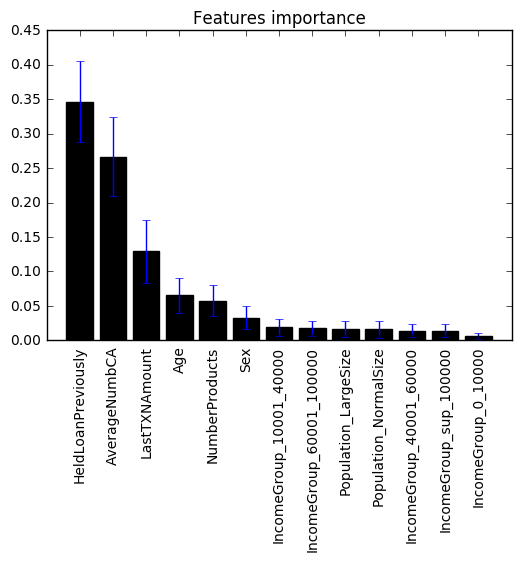

In [106]:
import matplotlib.pyplot as plt
importances = extratree_clf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in extratree_clf.estimators_],axis=0)

fig, ax = plt.subplots(1)

ax.bar(range(X.shape[1]), importances[indices],color="k", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices])
plt.xlim([-1, X.shape[1]])
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
plt.title('Features importance')
plt.show();


### 3.3. Likelihood definition

In [107]:
y_pred_prob = extratree_clf.predict_proba(X_test)
y_pred_prob

array([[ 0.76514907,  0.23485093],
       [ 0.98971549,  0.01028451],
       [ 1.        ,  0.        ],
       ..., 
       [ 0.94979815,  0.05020185],
       [ 0.80880247,  0.19119753],
       [ 0.88547999,  0.11452001]])

(array([ 35.,  30.,  23.,  19.,  13.,  15.,   7.,   3.,   4.,   4.]),
 array([ 0.50029227,  0.53452729,  0.56876232,  0.60299734,  0.63723237,
         0.67146739,  0.70570241,  0.73993744,  0.77417246,  0.80840748,
         0.84264251]),
 <a list of 10 Patch objects>)

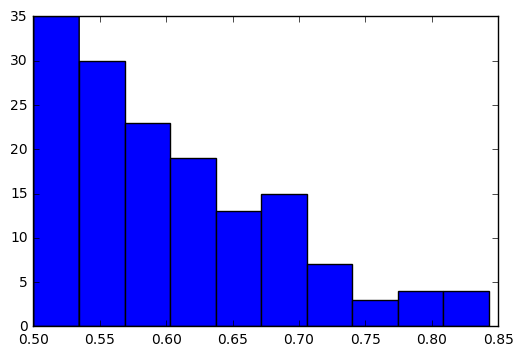

In [108]:
%matplotlib inline
index_loan = np.where(y_pred==1)
distrib_loan_prob = y_pred_prob[index_loan,1]
plt.hist(distrib_loan_prob[0])

### Since the probabilities are not very high let us define the likelihood as follows:

- VeryLowLikelihood = [0.50, 0.55]
- LowLikelihood = [0.60, 0.65]
- MediumLikelihood = [0.65, 0.70]
- HighLikelihood = [0.70, 0.80]
- VeryHighLikelihood = [0.80, 1]

The function **likelihoodLoan** allows encoding the probability into likelihood categories

In [109]:
def likelihoodLoan(label_predicted_proba):
    # label_predicted_proba has as shape : (n,2) 
    # where n is the size of sample 
    # and the column are respectively the proba to not take up or to take up a loan
    
    n = len(label_predicted_proba)
    group = ['' for i in range(n)]
    
    VeryLowLikelihood = np.where((label_predicted_proba[:,1] > 0.50) & (label_predicted_proba[:,1] < 0.55))[0]
    LowLikelihood = np.where((label_predicted_proba[:,1] >= 0.60) & (label_predicted_proba[:,1] < 0.65))[0]
    MediumLikelihood = np.where((label_predicted_proba[:,1] > 0.65) & (label_predicted_proba[:,1] < 0.70))[0]
    HighLikelihood = np.where((label_predicted_proba[:,1] > 0.70) & (label_predicted_proba[:,1] < 0.80))[0]
    VeryHighLikelihood = np.where((label_predicted_proba[:,1] > 0.80))[0]

    for k in VeryLowLikelihood: group[k]='VeryLowLikelihood'
    for k in LowLikelihood: group[k]='LowLikelihood'
    for k in MediumLikelihood: group[k]='MediumLikelihood'
    for k in HighLikelihood: group[k]='HighLikelihood'
    for k in VeryHighLikelihood: group[k]='VeryHighLikelihood'
    return group


# 4. Loan Prediction of the 2000 test customers

In [110]:
X_train.columns

Index(['Age', 'Sex', 'HeldLoanPreviously', 'NumberProducts', 'LastTXNAmount',
       'AverageNumbCA', 'IncomeGroup_0_10000', 'IncomeGroup_sup_100000',
       'IncomeGroup_10001_40000', 'IncomeGroup_40001_60000',
       'IncomeGroup_60001_100000', 'Population_LargeSize',
       'Population_NormalSize'],
      dtype='object')

In [111]:
test_ClientID = df_test.ClientID

In [112]:
test_data = df_test.drop('ClientID',axis=1)

In [113]:
test_data.columns

Index(['Age', 'Sex', 'HeldLoanPreviously', 'NumberProducts', 'LastTXNAmount',
       'AverageNumbCA', 'IncomeGroup_0_10000', 'IncomeGroup_sup_100000',
       'IncomeGroup_10001_40000', 'IncomeGroup_40001_60000',
       'IncomeGroup_60001_100000', 'Population_LargeSize',
       'Population_NormalSize'],
      dtype='object')

In [114]:
y_pred = extratree_clf.predict(test_data)
y_pred_proba = extratree_clf.predict_proba(test_data)

In [115]:
Likelihood = likelihoodLoan(y_pred_proba)

In [116]:
result = pd.DataFrame({'ClientID':test_ClientID, 'LoanFlag':y_pred,'LoanLikelihood':Likelihood})

In [117]:
result.head()

,ClientID,LoanFlag,LoanLikelihood
0,10001,0,
1,10002,0,
2,10003,0,
3,10004,0,
4,10005,0,


In [118]:
result.to_csv('Loan_prediction_results.csv',index=False)